# Forward-Variable Selection

In [1]:
import datetime
import pandas as pd
import numpy as np
import time
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector
from matplotlib import pyplot as plt

In [2]:
# Forward variable selection
M = 30 # Number of variables
n = 60 # sample size
replicates = 20

## Simulate data and calculate coefficients

In [3]:
def sample_x():
    mu = np.zeros(M)
    rho = np.random.uniform(0,1,1)
    e_xi_xj = np.zeros([M,M])

    for i in range(M):
        for j in range(M):
            e_xi_xj[i,j] = rho ** (abs(i-j))
    
    X = np.random.multivariate_normal(mean=mu, cov=e_xi_xj, size=n)
    return X

In [4]:
# Calculate coefficients
h = np.array([1,3,5]) 
k = np.array([5, 15, 25]) # cluster centers
m = np.arange(30) + 1
# Three sets of coefficients, with three clusters each 
beta_set1 = np.zeros([M,3])
beta_set2 = np.zeros([M,3])
beta_set3 = np.zeros([M,3])

for i in range(3):
    beta_set1[:,i] = np.maximum(h[0] - abs(m - k[i]),0) ** 2
    beta_set2[:,i] = np.maximum(h[1] - abs(m - k[i]),0) ** 2
    beta_set3[:,i] = np.maximum(h[2] - abs(m - k[i]),0) ** 2

In [5]:
beta_set1 = np.sum(beta_set1, axis=1)
beta_set2 = np.sum(beta_set2, axis=1)
beta_set3 = np.sum(beta_set3, axis=1)

In [6]:
# Check that the number of non-zero coefficients line up with the paper
assert(np.sum(beta_set1 != 0) == 3)
assert(np.sum(beta_set2 != 0) == 15)
assert(np.sum(beta_set3 != 0) == 27)

## Implement forward variable selection and bagging

In [7]:
def sample_bootstrap_reps(B, y_pred):
    np.random.seed(1000)
    # Randomly sample which of the 50 bootstrap reps we want to keep
    idxs = np.random.choice(np.arange(50), size=B, replace=False)
    y_pred_bag = y_pred[y_pred['bootstrap_rep'].isin(idxs)]
    return y_pred_bag

In [8]:
def fit_best_subset(X, y, m, idxs, b, run):
    sfs = SequentialFeatureSelector(LinearRegression(),
                                    k_features=m,
                                    forward=True,
                                    scoring='neg_mean_squared_error',
                                    cv=5)
    X_b = X[idxs,:]
    y_b = y[idxs]
    # Perform forward stepwise reg
    sfs = sfs.fit(X_b, y_b)
    # Fit model 
    X_sfs = sfs.transform(X_b)
    lm = LinearRegression()
    lm.fit(X_sfs, y_b)
    # Make predictions on original data
    y_pred = lm.predict(sfs.transform(X))
    y_pred = pd.DataFrame({'y_pred': y_pred, 'num_predictors':m, 'bootstrap_rep':b, 'iteration' : run, 'y' :y})   
    y_pred = y_pred.reset_index()
    return y_pred

### Set 1

In [9]:
start_time = time.time()
for i in range(5):
    np.random.seed(i)
    print("Running iteration {}".format(i))
    # Step (i)
    X = sample_x()
    epsilon = np.random.standard_normal(size=n)
    y = np.matmul(X, beta_set1) + epsilon

    # Step (ii)
    # Perform stepwise regression
    sfs = SequentialFeatureSelector(LinearRegression(),
                                    k_features=M,
                                    forward=True,
                                    scoring='neg_mean_squared_error',
                                    cv=5)
    selected_features = sfs.fit(X, y)
    results_c = pd.DataFrame.from_dict(selected_features.get_metric_dict()).T
    results_c['mse'] = results_c['avg_score'] * -1
    results_c = results_c.reset_index()
    if i == 0:
        results1 = results_c
    else:
        results1 = pd.concat([results_c, results1], ignore_index=True)
    
    # Step (iii)
    for j in range(50):
        np.random.seed(j)
        value = datetime.datetime.fromtimestamp(time.time())
        print(" {} Running bootstrap run {}".format(value.strftime('%Y-%m-%d %H:%M:%S'), j))
        # Generate indices for bootstrap replicatei t
        idxs = np.random.choice(np.arange(n), size=n, replace=True)
       
        # Perform stepwise regression
        for k in range(1,M+1):
            if i + j + k == 1:
                y_pred = fit_best_subset(X, y, k, idxs, j, i)
            else:
                y_pred = pd.concat([y_pred, fit_best_subset(X, y, k, idxs,j, i)])
                
end_time = time.time()
# Export output
results1.to_csv('subset1.csv')
y_pred.to_csv('bag_subset1.csv')

Running iteration 0
 2023-03-15 10:40:24 Running bootstrap run 0
 2023-03-15 10:40:59 Running bootstrap run 1
 2023-03-15 10:41:34 Running bootstrap run 2
 2023-03-15 10:42:08 Running bootstrap run 3
 2023-03-15 10:42:43 Running bootstrap run 4
 2023-03-15 10:43:17 Running bootstrap run 5
 2023-03-15 10:43:54 Running bootstrap run 6
 2023-03-15 10:44:29 Running bootstrap run 7
 2023-03-15 10:45:04 Running bootstrap run 8
 2023-03-15 10:45:39 Running bootstrap run 9
 2023-03-15 10:46:14 Running bootstrap run 10
 2023-03-15 10:46:50 Running bootstrap run 11
 2023-03-15 10:47:26 Running bootstrap run 12
 2023-03-15 10:48:02 Running bootstrap run 13
 2023-03-15 10:48:37 Running bootstrap run 14
 2023-03-15 10:49:12 Running bootstrap run 15
 2023-03-15 10:49:46 Running bootstrap run 16
 2023-03-15 10:50:21 Running bootstrap run 17
 2023-03-15 10:50:56 Running bootstrap run 18
 2023-03-15 10:51:31 Running bootstrap run 19
 2023-03-15 10:52:06 Running bootstrap run 20
 2023-03-15 10:52:41 Run

 2023-03-15 13:10:06 Running bootstrap run 28
 2023-03-15 13:10:45 Running bootstrap run 29
 2023-03-15 13:11:21 Running bootstrap run 30
 2023-03-15 13:11:57 Running bootstrap run 31
 2023-03-15 13:12:33 Running bootstrap run 32
 2023-03-15 13:13:10 Running bootstrap run 33
 2023-03-15 13:13:47 Running bootstrap run 34
 2023-03-15 13:14:24 Running bootstrap run 35
 2023-03-15 13:15:01 Running bootstrap run 36
 2023-03-15 13:15:38 Running bootstrap run 37
 2023-03-15 13:16:14 Running bootstrap run 38
 2023-03-15 13:16:51 Running bootstrap run 39
 2023-03-15 13:17:28 Running bootstrap run 40
 2023-03-15 13:18:06 Running bootstrap run 41
 2023-03-15 13:18:43 Running bootstrap run 42
 2023-03-15 13:19:21 Running bootstrap run 43
 2023-03-15 13:19:58 Running bootstrap run 44
 2023-03-15 13:20:35 Running bootstrap run 45
 2023-03-15 13:21:12 Running bootstrap run 46
 2023-03-15 13:21:49 Running bootstrap run 47
 2023-03-15 13:22:27 Running bootstrap run 48
 2023-03-15 13:23:04 Running boots

In [10]:
print((end_time - start_time)/60)

195.19160765012106


In [25]:
y_pred_bag = y_pred

In [32]:
y_pred_bag = sample_bootstrap_reps(50, y_pred)
# Average over all predictions from the bootstrap replicates by index for every iteration
y_pred_bag_mean = y_pred_bag.groupby(['num_predictors', 'index', 'iteration', 'y'])['y_pred'].mean().reset_index()
# Calculate MSE for each m-predictor model
y_pred_bag_mean['resid'] = (y_pred_bag_mean['y_pred'] - y_pred_bag_mean['y'])**2
e_b1 = y_pred_bag_mean.groupby(['num_predictors'])['resid'].mean()

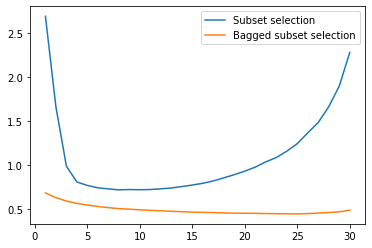

In [33]:
e_s1 = results1.groupby(['index'])['mse'].mean()
plt.plot(e_s1, label = 'Subset selection')
plt.plot(e_b1, label = 'Bagged subset selection')
plt.legend()

### Set 2

In [13]:
start_time = time.time()
for i in range(5):
    np.random.seed(i)
    print("Running iteration {}".format(i))
    # Step (i)
    X = sample_x()
    epsilon = np.random.standard_normal(size=n)
    y = np.matmul(X, beta_set2/100) + epsilon

    # Step (ii)
    # Perform stepwise regression
    sfs = SequentialFeatureSelector(LinearRegression(),
                                    k_features=M,
                                    forward=True,
                                    scoring='neg_mean_squared_error',
                                    cv=5)
    selected_features = sfs.fit(X, y)
    results_c = pd.DataFrame.from_dict(selected_features.get_metric_dict()).T
    results_c['mse'] = results_c['avg_score'] * -1
    results_c = results_c.reset_index()
    if i == 0:
        results2 = results_c
    else:
        results2 = pd.concat([results_c, results2], ignore_index=True)
    
    # Step (iii)
    for j in range(50):
        np.random.seed(j)
        value = datetime.datetime.fromtimestamp(time.time())
        print(" {} Running bootstrap run {}".format(value.strftime('%Y-%m-%d %H:%M:%S'), j))
        # Generate indices for bootstrap replicatei t
        idxs = np.random.choice(np.arange(n), size=n, replace=True)
       
        # Perform stepwise regression
        for k in range(1,M+1):
            if i + j + k == 1:
                y_pred = fit_best_subset(X, y, k, idxs, j, i)
            else:
                y_pred = pd.concat([y_pred, fit_best_subset(X, y, k, idxs,j, i)])
                
end_time = time.time()
# Export output
results2.to_csv('subset2.csv')
y_pred.to_csv('bag_subset2.csv')

Running iteration 0
 2023-03-15 13:55:38 Running bootstrap run 0
 2023-03-15 13:56:15 Running bootstrap run 1
 2023-03-15 13:56:53 Running bootstrap run 2
 2023-03-15 13:57:32 Running bootstrap run 3
 2023-03-15 13:58:10 Running bootstrap run 4
 2023-03-15 13:58:49 Running bootstrap run 5
 2023-03-15 13:59:29 Running bootstrap run 6
 2023-03-15 14:00:07 Running bootstrap run 7
 2023-03-15 14:00:46 Running bootstrap run 8
 2023-03-15 14:01:25 Running bootstrap run 9
 2023-03-15 14:02:03 Running bootstrap run 10
 2023-03-15 14:02:41 Running bootstrap run 11
 2023-03-15 14:03:23 Running bootstrap run 12
 2023-03-15 14:04:01 Running bootstrap run 13
 2023-03-15 14:04:40 Running bootstrap run 14
 2023-03-15 14:05:18 Running bootstrap run 15
 2023-03-15 14:05:56 Running bootstrap run 16
 2023-03-15 14:06:35 Running bootstrap run 17
 2023-03-15 14:07:12 Running bootstrap run 18
 2023-03-15 14:07:51 Running bootstrap run 19
 2023-03-15 14:08:29 Running bootstrap run 20
 2023-03-15 14:09:07 Run

 2023-03-15 16:35:36 Running bootstrap run 28
 2023-03-15 16:36:15 Running bootstrap run 29
 2023-03-15 16:36:54 Running bootstrap run 30
 2023-03-15 16:37:34 Running bootstrap run 31
 2023-03-15 16:38:13 Running bootstrap run 32
 2023-03-15 16:38:51 Running bootstrap run 33
 2023-03-15 16:39:30 Running bootstrap run 34
 2023-03-15 16:40:09 Running bootstrap run 35
 2023-03-15 16:40:48 Running bootstrap run 36
 2023-03-15 16:41:28 Running bootstrap run 37
 2023-03-15 16:42:08 Running bootstrap run 38
 2023-03-15 16:42:47 Running bootstrap run 39
 2023-03-15 16:43:26 Running bootstrap run 40
 2023-03-15 16:44:06 Running bootstrap run 41
 2023-03-15 16:44:45 Running bootstrap run 42
 2023-03-15 16:45:23 Running bootstrap run 43
 2023-03-15 16:46:03 Running bootstrap run 44
 2023-03-15 16:46:43 Running bootstrap run 45
 2023-03-15 16:47:22 Running bootstrap run 46
 2023-03-15 16:48:01 Running bootstrap run 47
 2023-03-15 16:48:40 Running bootstrap run 48
 2023-03-15 16:49:19 Running boots

In [14]:
y_pred_bag = sample_bootstrap_reps(10, y_pred)
# Average over all predictions from the bootstrap replicates by index for every iteration
y_pred_bag_mean = y_pred_bag.groupby(['num_predictors', 'index', 'iteration', 'y'])['y_pred'].mean().reset_index()
# Calculate MSE for each m-predictor model
y_pred_bag_mean['resid'] = (y_pred_bag_mean['y_pred'] - y_pred_bag_mean['y'])**2
e_b2 = y_pred_bag_mean.groupby(['num_predictors'])['resid'].mean()

In [15]:
print((end_time - start_time)/60)

207.65554525057476


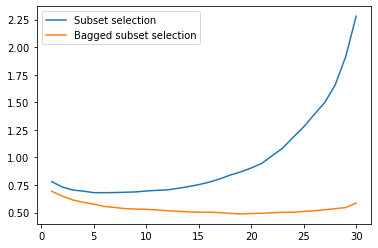

In [16]:
e_s2 = results2.groupby(['index'])['mse'].mean()
plt.plot(e_s2, label = 'Subset selection')
plt.plot(e_b2, label = 'Bagged subset selection')
plt.legend()

### Set 3

In [17]:
start_time = time.time()
for i in range(5):
    np.random.seed(i)
    print("Running iteration {}".format(i))
    # Step (i)
    X = sample_x()
    epsilon = np.random.standard_normal(size=n)
    y = np.matmul(X, beta_set3/1000) + epsilon

    # Step (ii)
    # Perform stepwise regression
    sfs = SequentialFeatureSelector(LinearRegression(),
                                    k_features=M,
                                    forward=True,
                                    scoring='neg_mean_squared_error',
                                    cv=5)
    selected_features = sfs.fit(X, y)
    results_c = pd.DataFrame.from_dict(selected_features.get_metric_dict()).T
    results_c['mse'] = results_c['avg_score'] * -1
    results_c = results_c.reset_index()
    if i == 0:
        results3 = results_c
    else:
        results3 = pd.concat([results_c, results3], ignore_index=True)
    
    # Step (iii)
    for j in range(50):
        np.random.seed(j)
        value = datetime.datetime.fromtimestamp(time.time())
        print(" {} Running bootstrap run {}".format(value.strftime('%Y-%m-%d %H:%M:%S'), j))
        # Generate indices for bootstrap replicatei t
        idxs = np.random.choice(np.arange(n), size=n, replace=True)
       
        # Perform stepwise regression
        for k in range(1,M+1):
            if i + j + k == 1:
                y_pred = fit_best_subset(X, y, k, idxs, j, i)
            else:
                y_pred = pd.concat([y_pred, fit_best_subset(X, y, k, idxs,j, i)])
                
end_time = time.time()
# Export output
results3.to_csv('subset3.csv')
y_pred.to_csv('bag_subset3.csv')

Running iteration 0
 2023-03-15 17:23:19 Running bootstrap run 0
 2023-03-15 17:23:57 Running bootstrap run 1
 2023-03-15 17:24:36 Running bootstrap run 2
 2023-03-15 17:25:16 Running bootstrap run 3
 2023-03-15 17:25:56 Running bootstrap run 4
 2023-03-15 17:26:35 Running bootstrap run 5
 2023-03-15 17:27:14 Running bootstrap run 6
 2023-03-15 17:27:53 Running bootstrap run 7
 2023-03-15 17:28:32 Running bootstrap run 8
 2023-03-15 17:29:11 Running bootstrap run 9
 2023-03-15 17:30:31 Running bootstrap run 10
 2023-03-15 17:31:07 Running bootstrap run 11
 2023-03-15 17:31:45 Running bootstrap run 12
 2023-03-15 17:32:22 Running bootstrap run 13
 2023-03-15 17:33:00 Running bootstrap run 14
 2023-03-15 17:33:38 Running bootstrap run 15
 2023-03-15 17:34:16 Running bootstrap run 16
 2023-03-15 17:34:54 Running bootstrap run 17
 2023-03-15 17:35:33 Running bootstrap run 18
 2023-03-15 17:36:12 Running bootstrap run 19
 2023-03-15 17:36:50 Running bootstrap run 20
 2023-03-15 17:37:29 Run

 2023-03-15 19:44:39 Running bootstrap run 28
 2023-03-15 19:45:16 Running bootstrap run 29
 2023-03-15 19:45:52 Running bootstrap run 30
 2023-03-15 19:46:29 Running bootstrap run 31
 2023-03-15 19:47:06 Running bootstrap run 32
 2023-03-15 19:47:43 Running bootstrap run 33
 2023-03-15 19:48:20 Running bootstrap run 34
 2023-03-15 19:48:57 Running bootstrap run 35
 2023-03-15 19:49:34 Running bootstrap run 36
 2023-03-15 19:50:12 Running bootstrap run 37
 2023-03-15 19:50:50 Running bootstrap run 38
 2023-03-15 19:51:27 Running bootstrap run 39
 2023-03-15 19:52:05 Running bootstrap run 40
 2023-03-15 19:52:43 Running bootstrap run 41
 2023-03-15 19:53:21 Running bootstrap run 42
 2023-03-15 19:53:58 Running bootstrap run 43
 2023-03-15 19:54:38 Running bootstrap run 44
 2023-03-15 19:55:16 Running bootstrap run 45
 2023-03-15 19:55:54 Running bootstrap run 46
 2023-03-15 19:56:32 Running bootstrap run 47
 2023-03-15 19:57:09 Running bootstrap run 48
 2023-03-15 19:57:46 Running boots

In [18]:
y_pred_bag = sample_bootstrap_reps(10, y_pred)
# Average over all predictions from the bootstrap replicates by index for every iteration
y_pred_bag_mean = y_pred.groupby(['num_predictors', 'index', 'iteration', 'y'])['y_pred'].mean().reset_index()
# Calculate MSE for each m-predictor model
y_pred_bag_mean['resid'] = (y_pred_bag_mean['y_pred'] - y_pred_bag_mean['y'])**2
e_b3 = y_pred_bag_mean.groupby(['num_predictors'])['resid'].mean()

In [19]:
print((end_time - start_time)/60)

186.79234194755554


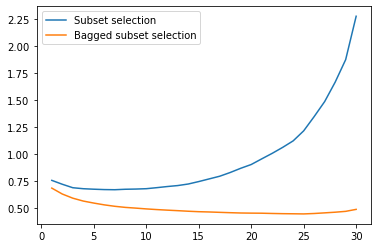

In [20]:
e_s3 = results3.groupby(['index'])['mse'].mean()
plt.plot(e_s3, label = 'Subset selection')
plt.plot(e_b3, label = 'Bagged subset selection')
plt.legend()

In [24]:
e_s3 - e_s2

index
1    -0.021281
2    -0.009098
3    -0.014342
4    -0.013061
5    -0.003983
6    -0.007063
7    -0.009621
8    -0.008264
9    -0.009211
10   -0.014382
11   -0.010778
12   -0.003758
13   -0.009136
14   -0.010363
15   -0.005959
16   -0.003279
17   -0.007783
18   -0.008397
19    0.002067
20    0.000809
21    0.012620
22   -0.006431
23   -0.019869
24   -0.057719
25   -0.059299
26   -0.038793
27   -0.007547
28    0.012015
29   -0.034905
30    0.000000
Name: mse, dtype: float64

Observations 
1. Increasing number of outer loop iterations doesn't hugely change anything.